## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Nan Fletcher-Lloyd, Antigone Fogel, Anastasia Gailly de Taurine, Iona Biggart, Payam Barnaghi
**Spring 2026**



# Neural Networks

This tutorial will focus on Neural Networks, and will rely on [scikit-learn's](https://scikit-learn.org/stable/index.html) and [pytorch's](https://pytorch.org) python packages.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !git clone https://github.com/ML4NS/ml4ns.github.io
  from distutils.dir_util import copy_tree
  copy_tree("ml4ns.github.io/labs/06 - Neural Networks/", "./")
  !pip install -r ml4ns.github.io/labs/requirements.txt

In [1]:
# importing packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.datasets as datasets
import numpy as np
import pandas as pd
import tqdm

# import plotting functions
import matplotlib.pyplot as plt
import matplotlib.colors

# setting the default colours for the plots
from cycler import cycler
binary_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ['#332288', 'white', '#AA4499']
)
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[
        '#332288','#88CCEE','#44AA99','#117733','#999933',
        '#DDCC77','#CC6677','#882255','#AA4499'
    ]
    )

# class for holding the random state throughout the notebook.
# this keeps results consistent
class RandomState(object):
    def __init__(self, random_state=None):
        self.random_state = random_state
    def next(self, n=1):
        assert type(n) == int, "Ensure n is an integer"
        if n == 1:
            self.random_state,\
                out_state = np.random.default_rng(
                    self.random_state
                    ).integers(0, 1e9, size=(2,))
        else:
            self.random_state,\
                *out_state = np.random.default_rng(
                    self.random_state
                    ).integers(0, 1e9, size=(n+1,))
        
        return out_state

In [2]:
random_state = RandomState(42)

In [3]:
torch.manual_seed(random_state.next())

## What is `torch`?


Pytorch is a python package that allows you to build machine learning models. It is highly flexible and allows you to perform auto-differentiation ✨!

All weights, inputs and targets in pytorch are stored as `torch.Tensor`s, ([documentation](https://pytorch.org/docs/stable/tensors.html)) which are very similar to numpy arrays, in the sense that they hold values but they hold the magic of being differentiable automatically. This makes training neural networks possible.

All neural network layers and loss functions are built using `nn.Module`s ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)) which allow for differentiable manipulations of  `torch.Tensor`s.

## How to Train a Model

The basic pipeline for training a model is as follows:

<img src= "_dependents/pipeline.png" width="600" />

## The Building Blocks

To start, we will discuss the building blocks that go into a deep learning network. This will include how to access single layers, as well as the different types of activation functions that can be used to create non-linearity in models.

### A Single Neuron

The single neuron underpins much of deep learning, and is used in almost all deep learning models. In its most basic form, it is a vector of values that trasforms an incoming vector of data to a scalar value.

### The Basics

We can create this single neuron easily with pytorch's `torch.nn.Linear` class:

In [9]:
# neuron that takes in 10 features and outputs 1 feature
sn = nn.Linear(10, 1, bias=False)

This is of the following form:

In [10]:
sn.weight.data

tensor([[-0.2477,  0.0100,  0.2894, -0.1227, -0.1487,  0.1072,  0.1092, -0.2329,
          0.2924, -0.0962]])

Given an input, this class will produce the output by multiplying each of the feature values with the values in the weights and then taking the sum. Let us see what this means:

In [11]:
input = torch.rand(
    size=(1,10), # 1 data point with 10 features
    requires_grad=False, # data point should not be updated
    )

Now, we transform the input using our single neuron:

In [12]:
sn(input)

tensor([[-0.0058]], grad_fn=<MmBackward0>)

Note that this output contains a `grad_fn`. This is pytorch's auto-grad system working in the background, ready to calculate the gradients to update weights in a model. We will see how this is used later.

Now, let's say that we want to have 5 neurons stacked on top of each other to transform a feature vector of size 10, to a feature vector of size 5. This can easily be done in the following way:


In [13]:
# 5 neurons acting together on the same input
fiven = nn.Linear(10, 5, bias=False)

This time, the weights are of shape `(n_output_features, n_input_features)`. This is because we have 5 neurons, each with 10 weights.

In [14]:
print("Weights:\n", fiven.weight.data)
print("Shape\n", fiven.weight.shape)

Weights:
 tensor([[-0.2963,  0.1853, -0.1030,  0.2333,  0.2648,  0.1953, -0.0987, -0.2739,
          0.2793,  0.2275],
        [ 0.1406, -0.0939, -0.0199, -0.2308, -0.0101,  0.3136,  0.2758, -0.2711,
         -0.0877,  0.1038],
        [-0.0037, -0.0498, -0.0947,  0.2193, -0.1711,  0.0496, -0.0726, -0.1235,
         -0.0096, -0.0742],
        [-0.1388,  0.0270,  0.0252, -0.1967, -0.0217,  0.1246, -0.1274,  0.2180,
         -0.0771, -0.3120],
        [-0.2351, -0.2541,  0.1325, -0.2841, -0.2728,  0.2335, -0.1153, -0.1621,
         -0.1728,  0.1860]])
Shape
 torch.Size([5, 10])


Now, given an input we get the following result:

In [11]:
# given an input
input = torch.rand(
    size=(1,10), # 1 data point with 10 features
    requires_grad=False, # data point should not be updated
    )

# we can get the output
fiven(input)

tensor([[ 0.0682, -0.2154,  0.0280, -0.1197, -0.2566]], grad_fn=<MmBackward0>)

This is the result of 5 neurons, each outputting a scalar value!

Pytorch allows you to stack these neurons vertically (acting on the same input) and horizontally (acting on the outputs from previous neurons). This will be discussed in the section [here](#a-feed-forward-network).

### Can We Train a Single Neuron?

Can we attempt to train this single neuron to replicate the equation: `y=mx+c`, for some `m` and `c`, and where `x` will be a 2d vector? Let's try!

In [15]:
m = torch.randn((1, 2), requires_grad=False) # a random m of size (1,2)
c = torch.randn(1, requires_grad=False) # a random c of size (1,)

print(f'The equation we are trying to predict is:\n y={np.round(m,2)}@x+{np.round(c,2)}')

The equation we are trying to predict is:
 y=tensor([[-1.6000,  1.5500]])@x+tensor([-0.2200])


Let's say our X is as follows:

In [16]:
# 10000 train random inputs between 0 and 1 with 5 features 
X_train = torch.rand(size=(10000, 2), requires_grad=False)
# 1000 val random inputs between 0 and 1 with 5 features 
X_val = torch.rand(size=(1000, 2), requires_grad=False)

In [17]:
# normalise the data
scaler = StandardScaler() # define scaler
X_train = torch.tensor(scaler.fit_transform(X_train)).float() # fit scaler and transform data and convert to tensor
X_val = torch.tensor(scaler.transform(X_train)).float() # transform data and convert to tensor

Now, for each of the 10000 samples, we can calculate the output of our single neuron:

In [18]:
# with our equation, this gives the y values
y_train = X_train@m.T + c
y_val = X_val@m.T + c

print(f'The y outputs are of shape {y_train.shape}')

The y outputs are of shape torch.Size([10000, 1])


To train a model to fit this, we need to define the architecture of the model. This is somewhere where you can add your prior knowledge to the process. Since we know that we are trying to fit a linear model, we will just use a single neuron. We can define this as follows:

In [19]:
# since here bias=True, this single neuron will take care of the m and c at the same time
sn = nn.Linear(2,1, bias=True)

In [20]:
print(f"To start with, the single neuron has weights:\n {sn.weight.data}")
print(f"and bias:\n {sn.bias.data}")

To start with, the single neuron has weights:
 tensor([[-0.0409, -0.3252]])
and bias:
 tensor([-0.6587])


To train this model, we will pass the `X` through the model and see how close it was to the true `y`.

In [21]:
print(f"The first 5 predictions are:\n {sn(X_train)[:5]}"\
    f"\n The first 5 true values are:\n {y_train[:5]}")

The first 5 predictions are:
 tensor([[-0.5923],
        [-0.5787],
        [-0.1378],
        [-0.5409],
        [-0.6849]], grad_fn=<SliceBackward0>)
 The first 5 true values are:
 tensor([[-2.2865],
        [-0.4751],
        [-3.6750],
        [ 1.4042],
        [-2.1630]])


At the moment this doesn't replicate the original function very well. We will therefore train this model using gradient descent to get it to perform better.

Now we can train this model (and by extension any model) using the following code:

For ease of training later in this notebook, the following code snippet will be added to the file `model_trainer.py` in this directory.

In [22]:
# define training function that can be used 
# with any model, loss function, data and optimiser
def train(
    model, train_loader, n_epochs, optimiser, criterion, val_loader=None
    ):
    '''
    A function to train any model with a given dataset, optimiser, and 
    criterion (loss function).

    Arguments
    ---------
    
    - model: pytorch nn object:
        The model to train
    - train_loader: pytorch data loader:
        The data to train with.
    - n_epochs: integer:
        The number of epochs to train for.
    - optimiser: pytorch optimiser:
        The optimiser to make the model updates.
    - criterion: pytorch nn object:
        The loss function to calculate the loss with.
    - val_loader: pytorch data loader:
        The data to calculate the validation loss with.
    
    Returns
    ---------
    
    - model: pytorch nn object:
        Trained version of the model given
        as an input.
    - tuple of dictionaries:
        - train_loss_dict: dictionary:
            Dictionary containing the training loss
            with keys: `steps` and `loss`.
        - val_loss_dict
            Dictionary containing the validation loss
            with keys: `steps` and `loss`.

    '''
    # check if GPU is available and use that if so
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # ==== push model to GPU if available ====
    model.to(device)

    # note that since all the following functions in this 
    # function rely on the inputs above, 
    # they won't work outside of the train function

    # pass a single batch of data through the model and get loss
    def batch_loss(inputs, targets):
        # ==== push data to GPU if available ====
        inputs, targets = inputs.to(device), targets.to(device)
        # ==== forward pass ====
        outputs = model(inputs)
        # ==== calc and save loss ====
        loss = criterion(outputs, targets)
        # ==== return loss ====
        return loss
    
    # train for an epoch
    def train_epoch(train_loader):
        model.train() # set model option to train - important if using dropout or batchnorm
        batch_loss_list = [] # we will store all losses in a list
        # for each batch in the train loader
        for nb, (inputs, targets) in enumerate(train_loader):
            # ==== set gradient to zero ====
            optimiser.zero_grad() # really important! Common mistake to not do this!
            # run data through batch_loss function to get loss
            loss = batch_loss(inputs=inputs, targets=targets)
            # ==== calc backprop gradients ====
            loss.backward()
            # ==== perform update step ====
            optimiser.step()
            # ==== store loss for later ====
            batch_loss_list.append(loss.item())
        # ==== return loss over batch ====
        return batch_loss_list

    # perform an epoch over the validation data to get loss
    @torch.no_grad() # dont want gradients in validation since we're not training
    def val_epoch(val_loader):
        model.eval() # set model option to eval - important if using dropout or batchnorm
        batch_loss_list = [] # we will store all losses in a list
        # for each batch in the val loader
        for nb, (inputs, targets) in enumerate(val_loader):   
            # ==== set gradient to zero ====
            optimiser.zero_grad() # gradients shouldnt be calculated but good practise 
            # run data through batch to get loss
            loss = batch_loss(inputs=inputs, targets=targets)
            # ==== store loss for later ====
            batch_loss_list.append(loss.item())
        # ==== calculate average loss ====
        return batch_loss_list


    pbar = tqdm.tqdm(desc='Training', total=n_epochs) # progress bar
    # loss stats
    train_loss_dict = {'step': [], 'loss': []}
    val_loss_dict = {'step': [], 'loss': []}

    # train for the given n_epochs
    for epoch in range(n_epochs):
        # ==== train for an epoch ====
        n_batches = len(train_loader)
        batch_lost_list_train = train_epoch(train_loader=train_loader)
        # ==== get loss stats ====
        train_loss_dict['loss'].extend(batch_lost_list_train) # adding loss
        # adding step values. These are the number of steps from the beginning
        train_loss_dict['step'].extend(
            list(np.arange(epoch*n_batches, (epoch+1)*n_batches)+1) 
            )
        avg_loss_train = np.mean(batch_lost_list_train)

        # if a validation loader is passed
        if val_loader is not None:  
            # ==== epoch over validation ====
            batch_lost_list_val = val_epoch(val_loader=val_loader)
            # ==== get loss stats ====
            avg_loss_val = np.mean(batch_lost_list_val)
            val_loss_dict['loss'].append(avg_loss_val)
            val_loss_dict['step'].append(
                (epoch+1)*n_batches+1 # the number of new steps is as many as the train loader
                )
        else:
            avg_loss_val = np.nan

        # ==== set pbar info and update ====
        pbar.set_postfix(
            {
                'Train Loss': f"{avg_loss_train:.3f}",
                'Val Loss': f"{avg_loss_val:.3f}"
                }
            )
        pbar.update(1)
        pbar.refresh()
    
    # put the model back on the cpu
    model.to('cpu')

    return model, (train_loss_dict, val_loss_dict)

We then set the settings for the training, including the number of epochs

In [23]:
# the number of times to run through the whole dataset
n_epochs = 10
# the batch size for the data
batch_size = 512

# wrap data in dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# put dataset in train loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    )

To do this, we need a loss function and an optimiser:

In [24]:
# pytorch has lots of optimisers available for use. Here we use SGD:
optimiser = torch.optim.SGD(
    params=sn.parameters(), # need to pass the optimiser the model parameters
    lr=0.01 # and the learning rate
    )

# pytorch also has lots of loss functions available. We can also easily make our own.
# to start, we will use the mean squarred error:
criterion = nn.MSELoss()

And calling the training function:

In [25]:
sn, (train_loss_dict, val_loss_dict) = train(
    model=sn,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )

Training: 100%|██████████| 10/10 [00:00<00:00, 26.85it/s, Train Loss=0.003, Val Loss=0.022]


Let's see what the loss looks like:

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/4252901983.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


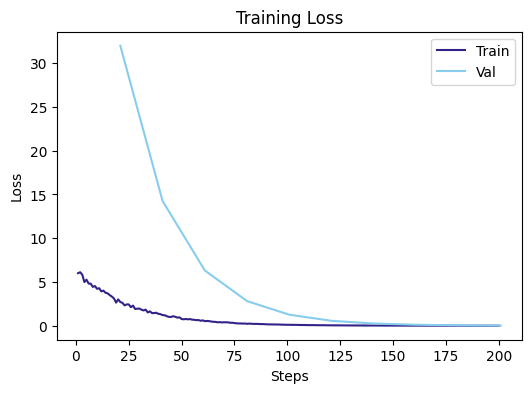

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot validation loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
# show plot
fig.show()

Did the values look like the true equation? Let's see:

In [27]:
print(f"After training, the single neuron has weights:\n {sn.weight.data}")
print(f"and bias:\n {sn.bias.data}")

After training, the single neuron has weights:
 tensor([[-1.5756,  1.5193]])
and bias:
 tensor([-0.2238])


In [28]:
print(f"The true model weights:\n {m}")
print(f"and bias:\n {c}")

The true model weights:
 tensor([[-1.6030,  1.5523]])
and bias:
 tensor([-0.2161])


The model approximated the function well, and we can see that the validation loss in the graph above went to nearly 0. This tells us that the model didn't overfit.

As you will have seen from the linear models lab, this is essentially a linear regression model and training it in this way is not a good idea, since closed solutions exist! This is simply an example of one of the basic building blocks of a Neural Network. We will now turn our attention to some of the other building blocks of neural networks, and how we can use them to create complex machine learning models.

### Activation Functions

Activation functions are non-linear functions that are placed after a layer of neurons to produce non-linearity in outputs. To visualise this problem, let's try to solve the following classification problem with and without using non-linear activation functions:

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as datasets

Loading some synthetic data:

In [30]:
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-val splits:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train)).float()
X_val = torch.tensor(scaler.transform(X_val)).float()

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

This looks like:

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/2101400359.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


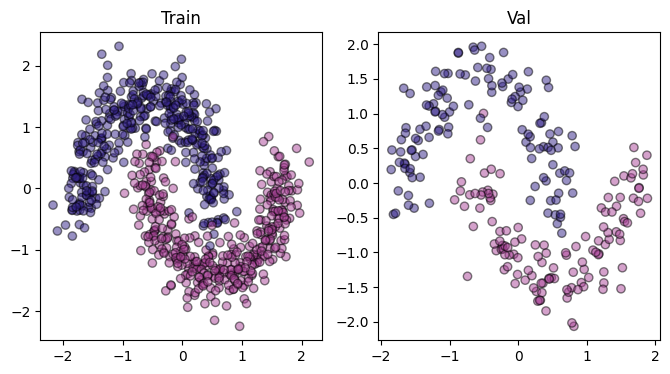

In [31]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_val[:,0], y=X_val[:,1], c=y_val, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Val')

fig.show()

Let us try and use a linear neuron model to classify this data. We expect this to be bad, since we know that this is a classification task, not a regression task and at the moment, we have only seen how to build a regression model

In [32]:
# since we won't be using activation functions,
# we need the result to be a float.
# we also need to reshape the data to (n_data_points, 1)
# we will see why later.
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

In [33]:
print(f"The shape of the input array is {X_train.shape} "\
    f"and the shape of the targets is {y_train_reg.shape}")

The shape of the input array is torch.Size([750, 2]) and the shape of the targets is torch.Size([750, 1])


The architecture for this model is as follows:

In [34]:
net = nn.Sequential(
    nn.Linear(X_train.shape[1], 100*X_train.shape[1]),
    nn.Linear(100*X_train.shape[1], 100*X_train.shape[1]),
    nn.Linear(100*X_train.shape[1], 1),
)
net

Sequential(
  (0): Linear(in_features=2, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
  (2): Linear(in_features=200, out_features=1, bias=True)
)

This is an input layer, two hidden layers and an output layer.

In [35]:
# this will only work in the same directory as the file `model_trainer`
from model_trainer import train

In [36]:
# the number of times to run through the whole dataset
n_epochs = 100
# the batch size for the data
batch_size = 128

# wrap data in dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train_reg)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val_reg)

# put dataset in train loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    )

In [37]:
# pytorch has lots of optimisers available for use. Here we use Adam:
optimiser = torch.optim.Adam(
    params=net.parameters(), # need to pass the optimiser the model parameters
    lr=0.001, # and the learning rate
    weight_decay=0.0001
    )

# mean squarred error is used since we are doing regression
criterion = nn.MSELoss()

In [38]:
sn, (train_loss_dict, val_loss_dict) = train(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )

Training: 100%|██████████| 100/100 [00:00<00:00, 207.46it/s, Train Loss=0.090, Val Loss=0.092]


/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/586285264.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


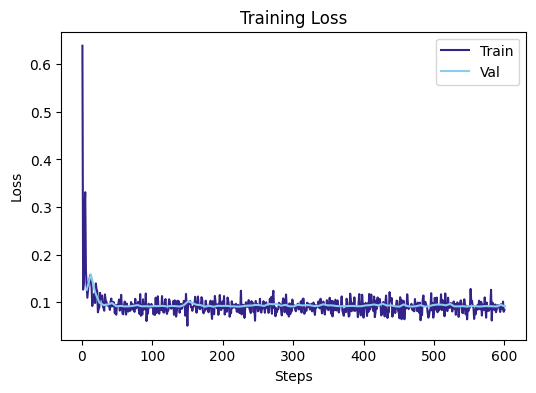

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
# show plot
fig.show()

In [40]:
print(f"A single prediction from the model looks as follows: {sn(X_train[0])}")

A single prediction from the model looks as follows: tensor([0.0723], grad_fn=<ViewBackward0>)


The above isn't really a prediction of label, and instead is a regression prediction of the label. Let's see what this decision boundary looks like on a graph:

In [41]:
# the code in this cell is not important and is written to enable us to 
# plot a decision boundary with a pytorch model
from decision_plotter import pytorch_decision_boundary

class PTtoDB(object):
    def __init__(self, model):
        self.model=model
    
    @torch.no_grad()
    def predict(self, inputs):
        if type(inputs) != torch.Tensor:
            inputs = torch.tensor(inputs).float()
        self.model.eval()
        return self.model(inputs).reshape(-1)

Let us look at the decision boundary.

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/763996045.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


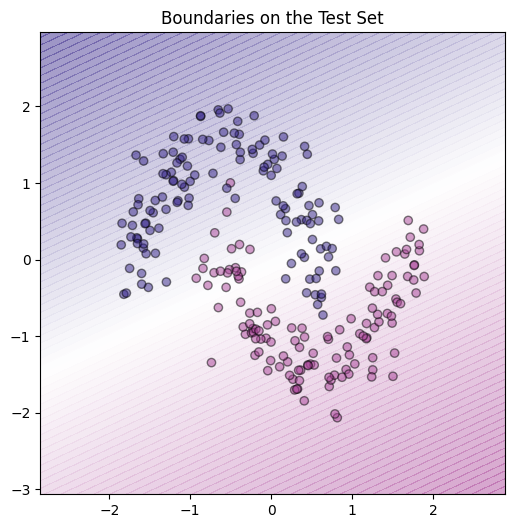

In [42]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax = pytorch_decision_boundary(PTtoDB(net), X=X_val, ax=ax, cmap=binary_cmap)
ax.scatter(x=X_val[:,0], y=X_val[:,1], c=y_val, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Boundaries on the Test Set')
fig.show()

To improve this, we will use activation layers to try and add non-linearity to our model and will use a loss function based on class labels instead of values.

In [43]:
nl = nn.Sequential(
    nn.Linear(X_train.shape[1], 100*X_train.shape[1]),
    nn.ReLU(), # non linear
    nn.Linear(100*X_train.shape[1], 100*X_train.shape[1]),
    nn.ReLU(), # non linear
    nn.Linear(100*X_train.shape[1], 2),
)

In [44]:
print(f"The shape of the input array is {X_train.shape} "\
    f"and the shape of the targets is {y_train.shape}")

The shape of the input array is torch.Size([750, 2]) and the shape of the targets is torch.Size([750])


In [45]:
# this will only work in the same directory as the file `model_trainer`
from model_trainer import train

In [46]:
# the number of times to run through the whole dataset
n_epochs = 100
# the batch size for the data
batch_size = 128

# wrapper data in dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# put dataset in train loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    )

In [47]:
# pytorch has lots of optimisers available for use. Here we use Adam:
optimiser = torch.optim.Adam(
    params=nl.parameters(), # need to pass the optimiser the model parameters
    lr=0.01, # and the learning rate
    weight_decay=0.0001
    )

# This time we will use cross entropy loss, 
# which includes a non-linear activation function
criterion = nn.CrossEntropyLoss()

In [48]:
nl, (train_loss_dict, val_loss_dict) = train(
    model=nl,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )

Training: 100%|██████████| 100/100 [00:00<00:00, 161.39it/s, Train Loss=0.019, Val Loss=0.033]


/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/586285264.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


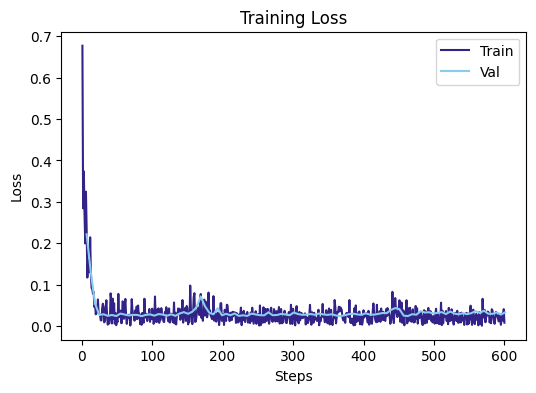

In [49]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
# show plot
fig.show()

In [50]:
print(f"A single prediction from the model "\
    f"looks as follows: {nl(X_train[0].unsqueeze(0))}")

A single prediction from the model looks as follows: tensor([[ 4.3355, -4.5872]], grad_fn=<AddmmBackward0>)


In [51]:
print(f"These values can easily be turned to probabilities "\
    f"as by using the softmax function:\n {F.softmax(nl(X_train[0].unsqueeze(0)), dim=1, )}")

These values can easily be turned to probabilities as by using the softmax function:
 tensor([[9.9987e-01, 1.3330e-04]], grad_fn=<SoftmaxBackward0>)


Let's see what the decision boundary looks like now:

In [52]:
# the code in this cell is not important and is written to enable us to 
# plot a decision boundary with a pytorch model
from decision_plotter import pytorch_decision_boundary

class PTtoDB(object):
    def __init__(self, model):
        self.model=model
    
    @torch.no_grad()
    def predict(self, inputs):
        if type(inputs) != torch.Tensor:
            inputs = torch.tensor(inputs).float()
        self.model.eval()
        output = self.model(inputs)
        probabilities =  F.softmax(output, dim=1)
        return probabilities[:,1].reshape(-1) # return probability of class 1

Let us look at the decision boundary. We will take the prediction as being the larger of the probabilities of the two classes.

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/1698677036.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


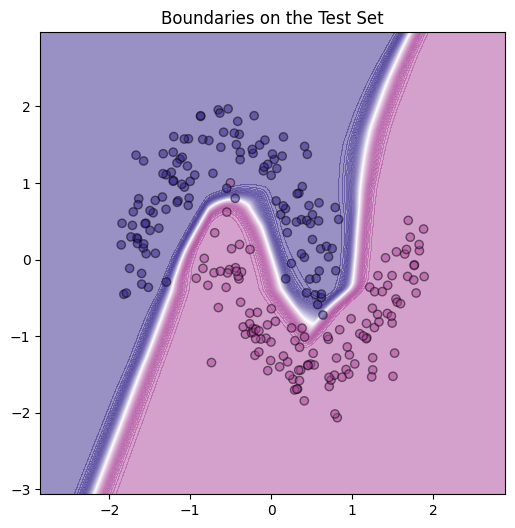

In [53]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax = pytorch_decision_boundary(PTtoDB(nl), X=X_val, ax=ax, cmap=binary_cmap)
ax.scatter(x=X_val[:,0], y=X_val[:,1], c=y_val, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Boundaries on the Test Set')
fig.show()

We can see that the decision bounday fits the data much closer! All we did was add a non-linear layer to the model and include a loss function that contains a non linear layer, as well as using a non-linear function to turn log-probabilities to probabilities.

Now that we understand the motivation behind using non linear activation functions, let's take a look at some of the most common functions:

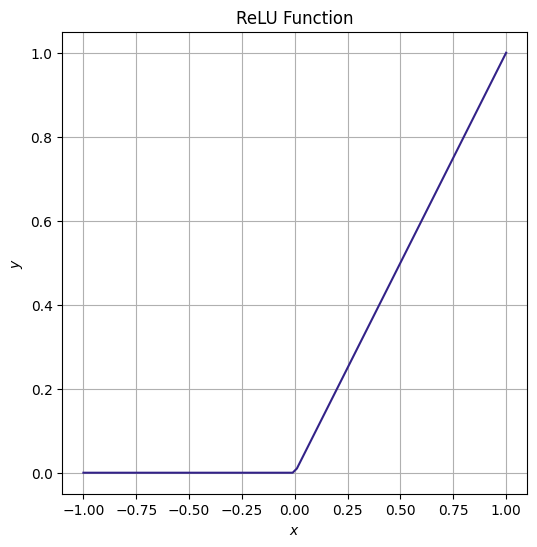

In [59]:
x = torch.linspace(-1,1,100)
y = F.relu(x)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(x, y)
ax.grid()
ax.set_ylabel('$y$')
ax.set_xlabel('$x$')
ax.set_title('ReLU Function')
plt.show()

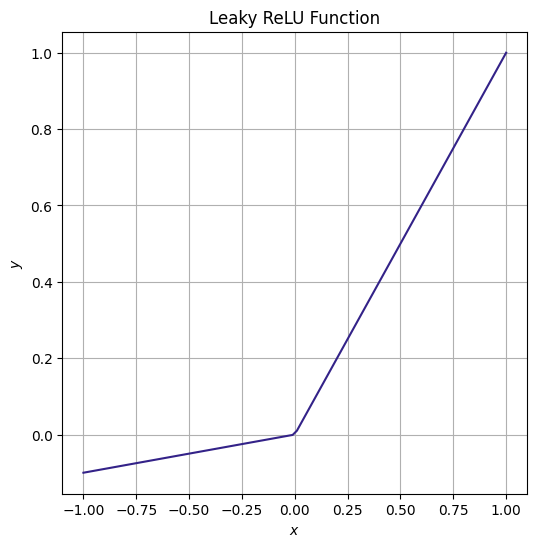

In [58]:
x = torch.linspace(-1,1,100)
y = F.leaky_relu(x, negative_slope=0.1)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(x, y)
ax.grid()
ax.set_ylabel('$y$')
ax.set_xlabel('$x$')
ax.set_title('Leaky ReLU Function')
plt.show()

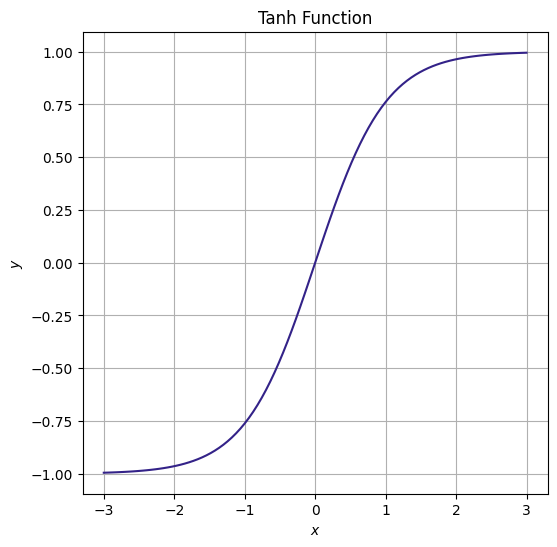

In [60]:
x = torch.linspace(-3,3,100)
y = F.tanh(x)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(x, y)
ax.grid()
ax.set_ylabel('$y$')
ax.set_xlabel('$x$')
ax.set_title('Tanh Function')
plt.show()

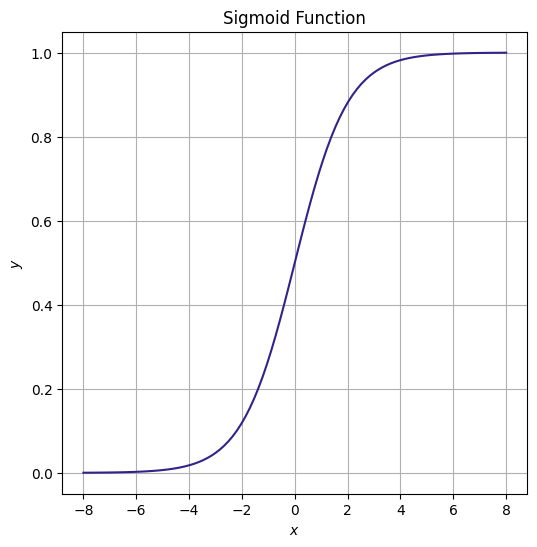

In [61]:
x = torch.linspace(-8,8,100)
y = F.sigmoid(x)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(x, y)
ax.grid()
ax.set_ylabel('$y$')
ax.set_xlabel('$x$')
ax.set_title('Sigmoid Function')
plt.show()

## A Feed Forward Network

Now that we have seen how to use a single layer of neurons and some of the most common activation functions, as well as studying how these models are trained we will now see how more complex networks can be built.

### Basics of Building a Network

Pytorch allows for the user to build complex, feed forward networks easily. Let us see how you might create a multi-layer perceptron:

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The `nn.Sequential` function (documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)) allows you to write a sequence with any number of `nn.Module` ([here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)) objects in order of execution. For example, a model with 3 layers of neurons in order can be written as follows:

In [63]:
input_size = 10 # example input size
output_size = 2 # example output size

# a 3 layer network mapping 10 features -> 2 features
# input -> hidden -> hidden -> output
ffn = nn.Sequential(
    nn.Linear(input_size, 20), # (layer_input_size, layer_output_size)
    nn.Linear(20, 20),
    nn.Linear(20, output_size),
    )

We can view the network by printing it:

In [64]:
print(ffn)

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=20, bias=True)
  (2): Linear(in_features=20, out_features=2, bias=True)
)


Adding non-linear layers is also simple, we simply add those to the `nn.Sequential` function:

In [65]:
input_size = 10 # example input size
output_size = 2 # example output size

# a 3 layer network mapping 10 features -> 2 features
nn.Sequential(
    nn.Linear(input_size, 20),
    nn.ReLU(), # relu function added
    nn.Linear(20, 20),
    nn.Tanh(), # tanh function added
    nn.Linear(20, output_size),
    nn.LeakyReLU(), # leaky relu added
    )

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=2, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
)

Similarly, to create more complicated models, like transformers, this can be as simple as:

In [66]:
# example transformer model 
nn.Sequential(
    nn.Linear(1000, 512),
    # transformers need a positional encoding layer here, see:
    # https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    # to learn how to add one.
    nn.Transformer(512, batch_first=True), 
    )

Sequential(
  (0): Linear(in_features=1000, out_features=512, bias=True)
  (1): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoder

As we can see, this is a much more complicated model!

If we want to build custom models or blocks, we can do the following using python classes and sub-classing the `nn.Module` class:

In [67]:
class FFBlock(nn.Module):
    def __init__(self, input_size, output_size):
        # always needs to be the first thing done when building a custom model
        super(FFBlock, self).__init__() 
        # defining a custom block
        self.net = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(),
            nn.BatchNorm1d(output_size), # can even add batch norm like this
            nn.Dropout(p=0.2) # dropout with rate = 0.2
            )
    def forward(self, inputs):
        return self.net(inputs)

Now we can use this class in other models too:

In [68]:
larger_ff_model = nn.Sequential(
    FFBlock(10, 100),
    FFBlock(100, 100),
    FFBlock(100, 100),
    nn.Linear(100, 2)
    )

This produces the model:

In [69]:
larger_ff_model

Sequential(
  (0): FFBlock(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (1): FFBlock(
    (net): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (2): FFBlock(
    (net): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (3): Linear(in_features=100, out_features=2, bias=True)
)

All of these models can be used in regression or classification tasks. In general:

- **Regression**: 
    - Ensure that the feature output size is the same as the output size of the targets.
    - Use a loss function designed for regression such as `nn.MSELoss`.
    - **Example**: Predicting the temperature tomorrow based on today's data.


- **Classification**:
    - Ensure that the feature output size is the same as the number of classes being predicted. For example, if you're performning binary classification output two features, etc. The outputs can be interpretted as the log-probability of the input being from the coressponding class. To get the actual probabilities, you can use `torch.nn.functional.softmax(outputs, dim=1)`. 
    - Use a loss function designed for classification such as `nn.CrossEntropyLoss`.
    - For multi-label classification (each data point can have multiple labels), you may want to use `nn.BCEWithLogitsLoss()`.
    - **Example**: Predicting whether it will rain or not tomorrow, or if doing multi-label classification, predicting whether it will rain tomorrow and/or the professor wears a tie to lectures tomorrow.

The following are examples of classification and regression:

In [70]:
# regression - 3 linear modules mapping 10 input features to 1 output feature
r_model = nn.Sequential(nn.Linear(10,10), nn.Linear(10,10), nn.Linear(10,1))
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(r_model.parameters(), lr=0.01)

# classification - 3 linear modules mapping 10 input features to 5 classes
c_model = nn.Sequential(nn.Linear(10,10), nn.Linear(10,10), nn.Linear(10,5))
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(c_model.parameters(), lr=0.01)

# multi-label classification - 3 linear modules mapping 10 input features to 5 attributes
mc_model = nn.Sequential(nn.Linear(10,10), nn.Linear(10,10), nn.Linear(10,5))
criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(mc_model.parameters(), lr=0.01)

### Maybe an Easier Way

If all you need is a multilayer perceptron (linear layers combined with drop out and non linear functions), then sklearn can provide this. See [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) and [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).

In [71]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [72]:
model = MLPClassifier()
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [73]:
model = MLPRegressor()
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

These models are great if you don't need anything custom and just want to have a simple network perform a classification or regression task. For example, let's look at the task we gave to our neural networks earlier:

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as datasets

Loading some synthetic data. These do not need to be tensors, since sklearn works on numpy arrays:

In [75]:
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-val splits:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

This looks like:

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/2101400359.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


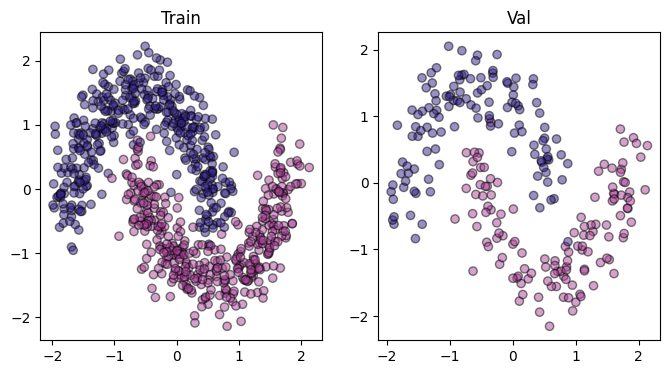

In [76]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_val[:,0], y=X_val[:,1], c=y_val, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Val')

fig.show()

In [77]:
# same as our pytorch model, but comes with extra performance options as default
mlp = MLPClassifier(
    hidden_layer_sizes=[
        100*X_train.shape[1],
        100*X_train.shape[1],
        ],
    activation='relu',
    solver='adam',
    batch_size=128,
    learning_rate='constant',
    learning_rate_init=0.01,
    random_state=random_state.next()
    )

In [78]:
mlp.fit(X_train, y_train)

MLPClassifier(batch_size=128, hidden_layer_sizes=[200, 200],
              learning_rate_init=0.01, random_state=462760238)

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/2714860653.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


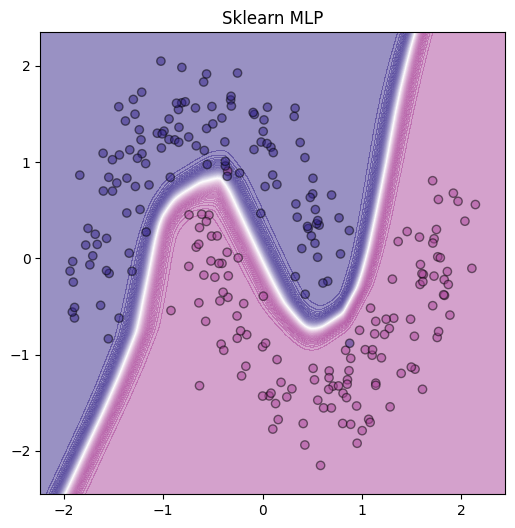

In [79]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=mlp,
    X=X_val,
    grid_resolution=200,
    plot_method='contourf',
    response_method='predict_proba',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_val[:,0], y=X_val[:,1], c=y_val, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Sklearn MLP')
fig.show()

As we can see, this was considerably easier to implement, and the `MLPClassifier` and `MLPRegressor` classes give you quick access to a wide variety of interesting options.

### An Example

Let's see how a feed forward network can be used to predict the [fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This is a simple dataset containing images of clothes. We will flatten these images so that it is possible to make predictions using a feed forward MLP. We will then compare the pytorch and sklearn implementations.

In [80]:
import torchvision # to get data
import torchvision.transforms as transforms

from dataset import MemoryDataset

In [81]:
transform_images = transforms.Compose([
                        transforms.PILToTensor(),
                        transforms.ConvertImageDtype(torch.float),
                        transforms.Normalize(mean=0, std=1),
                        nn.Flatten(start_dim=0),
                        ])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True, 
    transform=transform_images
    )

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True, 
    transform=transform_images
    )

# keeps data in memory after loading
train_dataset = MemoryDataset(train_dataset, now=False,)
test_dataset = MemoryDataset(test_dataset, now=False,)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 1.31MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 11.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.31MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



A few example images:

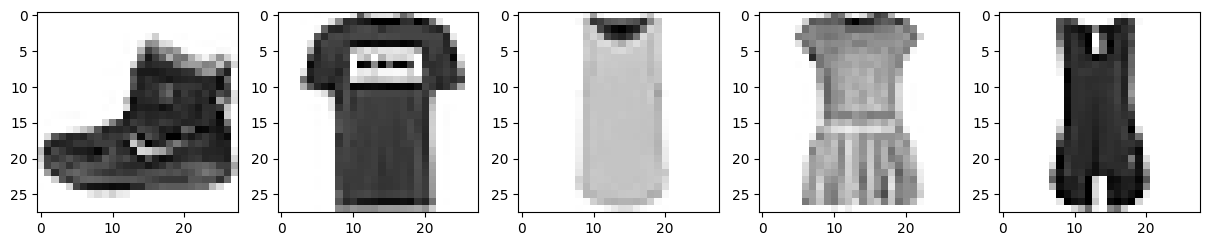

In [82]:
images_to_show = [train_dataset[i][0].reshape(28,28) for i in range(5)]

fig, axes = plt.subplots(1,5,figsize=(15,3))

for nax, ax in enumerate(axes):
    ax.imshow(
        images_to_show[nax].numpy(),
        cmap='Greys'
        )

Let us try and train a pytorch model:

In [83]:
# the training function we made
from model_trainer import train

In [84]:
# setting up the data loaders
# splitting the data into train and val
n_train_set, n_val_set = [
    int(0.75*len(train_dataset)), len(train_dataset)-int(0.75*len(train_dataset))
    ]

train_dataset_split, val_dataset_split = torch.utils.data.random_split(
    train_dataset, lengths=[n_train_set, n_val_set],
    )

# the number of times to run through the whole dataset
n_epochs = 10
# the batch size for the data
batch_size = 512

# put datasets in train loader
train_loader = torch.utils.data.DataLoader(
    train_dataset_split, batch_size=batch_size, shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset_split, batch_size=batch_size, shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    )

# model
mlp = nn.Sequential(
    nn.Linear(784, 16),
    nn.Dropout(0.2), # dropout can be easily added like this
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.Dropout(0.2), # dropout can be easily added like this
    nn.ReLU(),
    nn.Linear(16,10),
    )

optimiser = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

And finally, we will use our function to train the model:

In [85]:
# train the model
model, (train_loss_dict, val_loss_dict) = train(
    model=mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion
    )

Training: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s, Train Loss=0.627, Val Loss=0.469]


This gives us the loss plot:

/var/folders/yk/1mdm_q05399gtx0bzhc4tjrh0000gp/T/ipykernel_44645/586285264.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


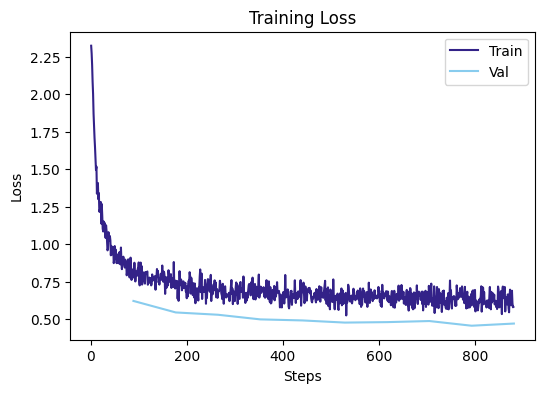

In [86]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
# show plot
fig.show()

To calculate the accuracy, we need to count the number of correct instances over the test loader:

Similarly to our training function, we can define a predictions function that can return the predictions, true labels, and the raw outputs:

In [87]:
@torch.no_grad() # no gradients to calculate
def predict(
    model:nn.Module, 
    test_loader:torch.utils.data.DataLoader,
    ):
    '''
    This function will iterate over the :code:`test_loader`
    and return the outputs of the model
    applied to the data.

    Arguments
    ---------

    - model: nn.Module:
        The model used to make predictions.

    - test_loader: torch.utils.data.DataLoader:
        The data to predict on.
    
    Returns
    ---------

    - outputs: torch.Tensor:
        The outputs of the model
    
    - labels: torch.Tensor:
        The ground truth labels collected
        from :code:`test_loader`.

    '''
    
    # lists to contain the output data
    targets = []
    outputs = []

    # adding model to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    # iterating over the test_loader with a progress bar
    for input, target in tqdm.tqdm(test_loader, desc='Predicting'):
        # ==== push data to GPU if available ====
        input = input.to(device)
        # ==== forward pass ====
        output = model(input)
        # ==== saving outputs and labels ====
        outputs.append(output.cpu())
        targets.append(target) # target was never pushed to GPU so remains on cpu
    
    # turning outputs into torch tensors instead of lists
    outputs = torch.cat(outputs)
    targets = torch.cat(targets)

    model.to('cpu') # return the model to the CPU

    return outputs, targets

We will save the above function in the file `model_predictor.py` so that we can import it easily later.

In [88]:
test_mlp_predictions, test_labels = predict(model, test_loader=test_loader)
# finding the class of max probability
_, test_mlp_predictions = torch.max(test_mlp_predictions, dim=1) 

Predicting: 100%|██████████| 20/20 [00:00<00:00, 50.20it/s]


In [89]:
from sklearn.metrics import accuracy_score

In [90]:
test_mlp_accuracy = accuracy_score(test_dataset.targets.numpy(), test_mlp_predictions.numpy())

In [91]:
print(f"The accuracy of the pytorch MLP is {test_mlp_accuracy*100:.2f}%")

The accuracy of the pytorch MLP is 82.86%


Now, let's see how well an sklearn MLP does:

In [92]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

Now we need to make numpy arrays from the same data used in the pytorch training:

In [93]:
# since the data originated from pytorch dataloaders, we need to turn these into numpy 
# arrays for our sklearn model

X_train, y_train = [], []
for inputs, targets in train_loader:
    X_train.append(inputs.numpy())
    y_train.append(targets.numpy())

X_val, y_val = [], []
for inputs, targets in val_loader:
    X_val.append(inputs.numpy())
    y_val.append(targets.numpy())

X_test, y_test = [], []
for inputs, targets in test_loader:
    X_test.append(inputs.numpy())
    y_test.append(targets.numpy())

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
X_val = np.vstack(X_val)
y_val = np.concatenate(y_val)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

In [94]:
# same as our pytorch model, but comes with extra performance options as default
# also MLPClassifier does not support dropout
mlp = MLPClassifier(
    hidden_layer_sizes=[
        16,
        16,        
        ],
    activation='relu',
    solver='adam',
    batch_size=512,
    learning_rate='constant',
    learning_rate_init=0.01,
    random_state=random_state.next()
    )

In [95]:
mlp.fit(X_train, y_train)

MLPClassifier(batch_size=512, hidden_layer_sizes=[16, 16],
              learning_rate_init=0.01, random_state=675442166)

In [96]:
test_mlp_sk_predictions = mlp.predict(X_test)

In [97]:
from sklearn.metrics import accuracy_score

In [98]:
test_mlp_sk_accuracy = accuracy_score(y_test, test_mlp_sk_predictions)

In [99]:
print(f"The accuracy of the pytorch MLP is {test_mlp_sk_accuracy*100:.2f}%")

The accuracy of the pytorch MLP is 85.09%


Here, Sklearn's model was arguably easier to implement, and performed better. However, when more complex datasets or models are being experimented with, Pytorch is required.

Also, pytorch allows you to keep all datasets on disk and ensures that large datasets do not cause memory problems. Sklearn prefers data to be in memory. This is why it ran faster here, since converting the data from pytorch datasets to numpy arrays loaded the data into memory.

## More Complex Neural Networks

We will now look at an example of training a complex model on ECG data, located online. This will also allow us to provide an example on how to build custom datasets from online data.

These more complicated examples require pytorch models and their flexibility:

In [100]:
# this will only work in the same directory as the file `model_trainer`
from model_trainer import train

Within the `dataset.py` file in this directory, we have provided an example of loading a complex ECG dataset from online ([here, PTB-XL](https://physionet.org/content/ptb-xl/1.0.0/)) and loading it in a pytorch dataset.

In [101]:
from dataset import PTB_XL, MemoryDataset

**NOTE:** The following code will download the ECG dataset and unpack it. This is quite a large dataset.

In [102]:
train_dataset = PTB_XL(
    data_path='./data/',
    train=True,
    sampling_rate=100,
    binary=True,
    )

test_dataset = PTB_XL(
    data_path='./data/',
    train=False,
    sampling_rate=100,
    binary=True,
    )

feature_names = train_dataset.feature_names

  3%|▎         | 64.3M/1.84G [02:51<1:18:46, 376kB/s] 


KeyboardInterrupt: 

What does this data look like?

In [96]:
idx_normal = np.argmax(train_dataset.targets == 0) # first normal ecg
idx_abnormal = np.argmax(train_dataset.targets == 1) # first abnormal ecg

/tmp/ipykernel_2624/1275029451.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


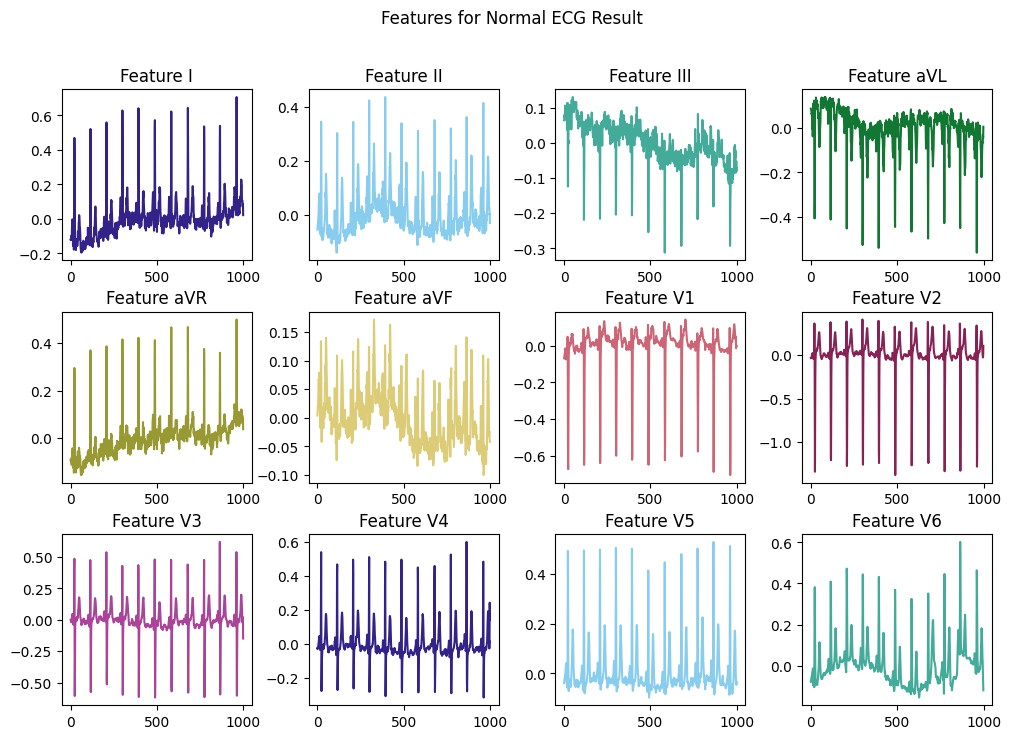

In [97]:
inputs, _ = train_dataset[idx_normal]

fig, axes = plt.subplots(3, inputs.shape[0]//3, figsize=(12,8))

# getting the colours to make the plot look nicer!
colors = plt.rcParams["axes.prop_cycle"]()

for nax, ax in enumerate(np.ravel(axes)):
    ax.plot(inputs[nax,:], color=next(colors)["color"])
    ax.set_title(f'Feature {feature_names[nax]}')

fig.suptitle('Features for Normal ECG Result')
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.show()

/tmp/ipykernel_2624/162699954.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


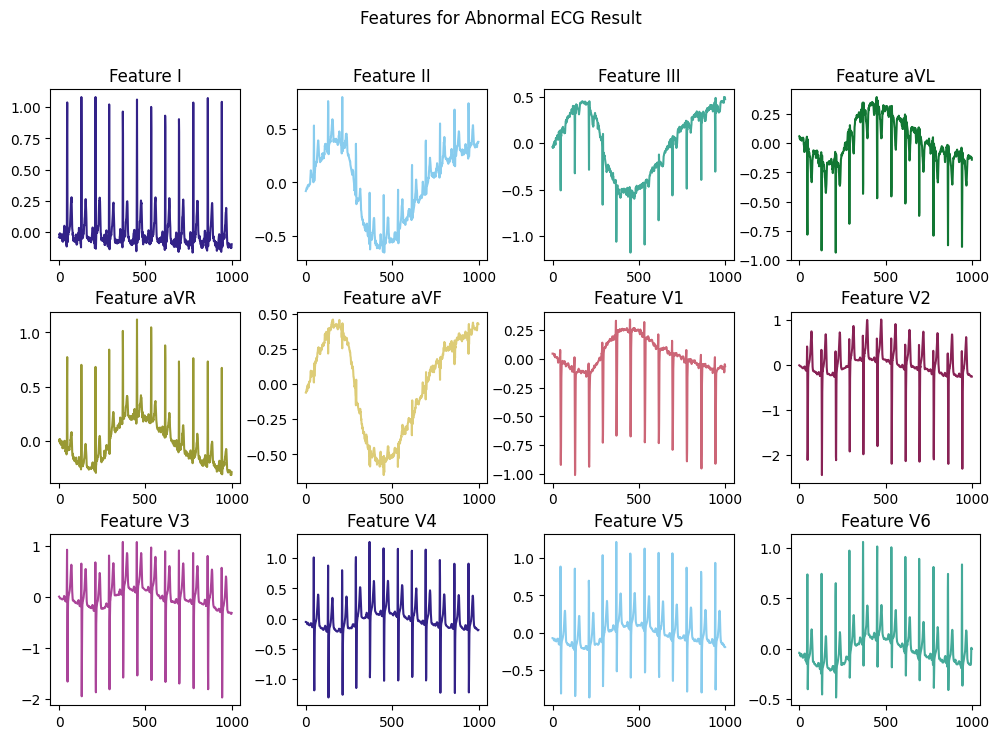

In [98]:
inputs, _ = train_dataset[idx_abnormal]

fig, axes = plt.subplots(3, inputs.shape[0]//3, figsize=(12,8))

# getting the colours to make the plot look nicer!
colors = plt.rcParams["axes.prop_cycle"]()

for nax, ax in enumerate(np.ravel(axes)):
    ax.plot(inputs[nax,:], color=next(colors)["color"])
    ax.set_title(f'Feature {feature_names[nax]}')

fig.suptitle('Features for Abnormal ECG Result')
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.show()

Within the `dataset.py` file, we have also given an example of a wrapper that can be built for a dataset to do interesting things! We have included a wrapper that loads all of the dataset into memory after the first epoch:

In [99]:
train_dataset = MemoryDataset(train_dataset, now=False)
test_dataset = MemoryDataset(test_dataset, now=False)

We now load a 1D ResNet model that will be used to train a model on this dataset. This is a complicated model, with skip connections and many layers. It is an example of how flexible pytorch can be:

To view the code for this model, feel free to look through the file `resnet.py`. 

In [100]:
# importing a ResNet model from the file resnet.py
from resnet import ResNet

Now, let's train this ResNet model to make predictions on an ECG dataset:

In [101]:
# setting up the data loaders
# splitting the data into train and val
n_train_set, n_val_set = [
    int(0.75*len(train_dataset)), len(train_dataset)-int(0.75*len(train_dataset))
    ]

train_dataset_split, val_dataset_split = torch.utils.data.random_split(
    train_dataset, lengths=[n_train_set, n_val_set],
    )

# the number of times to run through the whole dataset
n_epochs = 40
# the batch size for the data
batch_size = 4196

# put datasets in train loader
train_loader = torch.utils.data.DataLoader(
    train_dataset_split, batch_size=batch_size, shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset_split, batch_size=batch_size, shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    )

In [102]:
resnet = ResNet(
    input_dim=1000,
    input_channels=12,
    kernel_size=15,
    n_output=2,
    dropout_rate=0.2,
    )

optimiser = torch.optim.Adam(
    params=resnet.parameters(), 
    lr=0.001, 
    weight_decay=0.0001, 
    betas=(0.99, 0.999),
    )
criterion = nn.CrossEntropyLoss()

In [103]:
resnet

ResNet(
  (x1): Sequential(
    (0): Conv1d(12, 12, kernel_size=(15,), stride=(1,), padding=same, bias=False)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
  )
  (x2): Sequential(
    (0): ResBlock(
      (x1): Sequential(
        (0): Conv1d(12, 24, kernel_size=(15,), stride=(1,), padding=same, bias=False)
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
      (x2): Sequential(
        (0): Conv1d(24, 24, kernel_size=(15,), stride=(4,), bias=False)
      )
      (y1): Sequential(
        (0): Conv1d(12, 24, kernel_size=(15,), stride=(1,), padding=same, bias=False)
      )
      (xy1): Sequential(
        (0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
    )
    (1): ResBlock(
      (x1): Sequential(
      

In [104]:
# train the model
resnet, (train_loss_dict, val_loss_dict) = train(
    model=resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion
    )

Training: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it, Train Loss=0.270, Val Loss=0.376]


This gives us the loss plot:

/tmp/ipykernel_2624/586285264.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


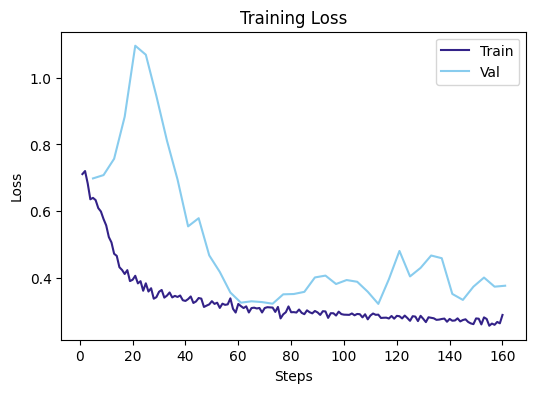

In [105]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
# show plot
fig.show()

In [106]:
# import the function we defined earlier for 
# making predictions on a test data loader
from model_predictor import predict

In [107]:
test_probabilities, test_targets = predict(resnet, test_loader=test_loader)
# finding the class of max probability
_, test_predictions = torch.max(test_probabilities, dim=1) 
test_probabilities = test_probabilities[:,1]

Predicting: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


In [108]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [109]:
test_resnet_accuracy = accuracy_score(
    test_targets.numpy(), test_predictions.numpy()
    )

In [110]:
print(f"The accuracy of the pytorch ResNet is {test_resnet_accuracy*100:.2f}%")

The accuracy of the pytorch ResNet is 83.17%


In [111]:
test_resnet_auc_roc = roc_auc_score(
    test_targets.numpy(), test_probabilities.numpy()
    )

In [112]:
print(f"The area under the ROC of the pytorch ResNet is {test_resnet_auc_roc*100:.2f}%")

The area under the ROC of the pytorch ResNet is 93.47%


Here, we trained a model to classify ECG results as normal or abnormal, and were able to get good accuracy and area under the ROC.